# Prepare Dataset

Download and prepare dataset for training

In [1]:
#@title Download Dataset
!rm -r *
!wget https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat.gz
!wget https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat.gz
!wget https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-info.mat.gz
!wget https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat.gz
!wget https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat.gz
!wget https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat.gz

!mkdir dataset
!mv *.gz dataset/
!gunzip dataset/*.gz
!rm dataset/*.gz



--2019-07-12 07:52:26--  https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat.gz
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131896188 (126M) [application/x-gzip]
Saving to: ‘smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat.gz’

smallnorb-5x46789x9 100%[===================>] 125.79M  14.8MB/s    in 10s     

2019-07-12 07:52:37 (12.0 MB/s) - ‘smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat.gz’ saved [131896188/131896188]

--2019-07-12 07:52:40--  https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat.gz
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348 [application/x-gzip]
Saving to: ‘smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat.gz’

In [2]:
#@title Download Dataset Parser
!git clone https://github.com/ndrplz/small_norb

Cloning into 'small_norb'...
remote: Enumerating objects: 79, done.
remote: Total 79 (delta 0), reused 0 (delta 0), pack-reused 79
Unpacking objects: 100% (79/79), done.


In [3]:
#@title Initialize Dataset Parser

from small_norb.smallnorb.dataset import SmallNORBDataset

dataset = SmallNORBDataset(dataset_root='dataset')
categories = ['animal', 'human', 'airplane', 'truck', 'car']

Loading info...: 100%|██████████| 24300/24300 [00:00<00:00, 315320.23it/s]


In [0]:
#@title Data Preprocessing Functions

import random
import numpy as np
from keras.utils import to_categorical

def split(dataset, conf):
  random.shuffle(dataset)
  
  # class based sets
  train_set = [ [] for i in range(len(categories)) ]
  val_set = [ [] for i in range(len(categories)) ]
  test_set = [ [] for i in range(len(categories)) ]
  
  for toy_set in dataset:
    cat = toy_set[0].category
    if len(val_set[cat]) < conf['val']:
      val_set[cat].append(toy_set)
    elif len(test_set[cat]) < conf['test']:
      test_set[cat].append(toy_set)
    else:
      train_set[cat].append(toy_set)
      
      
  train_set  = [toy_set for cat in train_set for toy_set in cat]
  val_set  = [toy_set for cat in val_set for toy_set in cat]
  test_set  = [toy_set for cat in test_set for toy_set in cat]
  return train_set, val_set, test_set

def filter(dataset, conf):
  x_values, y_values = [], []
  for toy_set in dataset:
    for sample in toy_set:
      if sample.elevation not in conf['elevation']:
        continue
      if sample.azimuth not in conf['azimuth']:
        continue
      if sample.lighting not in conf['lighting']:
        continue
        
      if sample.category in conf['categories']:
        if sample.elevation not in conf.categories[sample.category]['elevation']:
          continue
        if sample.azimuth not in conf.categories[sample.category]['azimuth']:
          continue
        if sample.lighting not in conf.categories[sample.category]['lighting']:
          continue
      x_values.append( np.expand_dims(sample.image_lt, axis=-1) )
      y_values.append( to_categorical(sample.category, len(categories) ) )
  return np.asarray(x_values), np.asarray(y_values)

def process(conf):
  # Get original test and train sets
  test_set = dataset.group_dataset_by_category_and_instance('test')
  train_set = dataset.group_dataset_by_category_and_instance('train')

  # Split dataset into train/val/test
  train_set, val_set, test_set = split( test_set + train_set, conf['split'] )

  # Preprocess datasets to match our configurations
  train_x, train_y = filter(train_set, conf['train'])
  val_x, val_y = filter(val_set, conf['train'])
  test_x, test_y = filter(test_set, conf['test'])
  
  return (train_x, train_y), (val_x, val_y), (test_x, test_y)

# Prepare Models

In [0]:
#@title LocalNormalization Definition
from keras.engine import Layer, InputSpec
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.layers import Input, Add, Dense,Dropout, Lambda

from keras.utils.generic_utils import get_custom_objects


class LocalNormalization(Layer):

    def __init__(self,
                 groupsize=32,
                 axis=0,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 batch_size = 100,
                 **kwargs):
        super(LocalNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groupsize
        self.batch_size = batch_size
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]
        
        if dim is None:
            dim = self.batch_size

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the batch size (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the batch size (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),axes={self.axis: dim})
        shape = (dim//self.groups,input_shape[-1])

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
       
        
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        
        div = lambda x:x//self.groups
        
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = div(self.batch_size)
        broadcast_shape[-1] = input_shape[-1]
        broadcast_shape.insert(1, 1)

        reshape_group_shape = K.int_shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = div(self.batch_size)
        group_axes.insert(1, self.groups)
        

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups]+group_axes[2:]
        group_shape = K.stack(group_shape)
        
        inputs = K.reshape(inputs, group_shape)
        
        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = [1,2,3]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        
        outputs = inputs
        
        # In this case we must explicitly broadcast all parameters.
        if self.scale:           
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma
            
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta
        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(LocalNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [0]:
#@title VGG Model Definition

from keras.models import Model
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras.regularizers import l2

def norm(norm_type, batch_size=None, groupsize=None):
  if norm_type=='batch':
    return BatchNormalization()
  elif norm_type=='local':
    return LocalNormalization(axis=0, batch_size=batch_size, groupsize=groupsize)
  return None

def build_model(name='vgg', input_shape=(96,96,1,), input_layer=None, nb_classes=5, weight_decay=0.0005, norm_type='batch', batch_size=128, group_size=8):  
  if input_layer is None:
    inputs = Input(shape=input_shape)
  else:
    inputs = input_layer
  x = inputs
  
  x = Conv2D(64, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(64, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(128, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(128, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(256, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(256, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(256, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)


  x = Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)


  x = Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = Conv2D(512, (3, 3), padding='same',kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)
  x = norm(norm_type, batch_size=batch_size, groupsize=group_size)(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.5)(x)

  x = Flatten()(x)
  x = Dense(512,kernel_regularizer=l2(weight_decay))(x)
  x = Activation('relu')(x)

  x = Dropout(0.5)(x)
  x = Dense(nb_classes)(x)
  x = Activation('softmax', name=name+'_output')(x)
  
  outputs = x
  return Model(name=name, inputs=inputs, outputs=outputs)

## Initialize Models

In [0]:
#@title Configure Models

nb_classes = 5
image_height = 96
image_width = 96
input_shape = (image_height, image_width, 1)
batch_size = 128
group_size = 4

inputs = Input(shape=input_shape)
model_batch = build_model(name='batch_vgg', input_layer=inputs, norm_type='batch', batch_size=batch_size, group_size=group_size, nb_classes=nb_classes)
model_local = build_model(name='local_vgg', input_layer=inputs, norm_type='local', batch_size=batch_size, group_size=group_size, nb_classes=nb_classes)

In [0]:
#@title (Optional) Load Weights

#model_batch.load_weights('weights-batch.h5')
#model_local.load_weights('weights-local.h5')

In [9]:
#@title (Deprecated) Combine Models

'''
from keras.optimizers import SGD

losses = {
	model_batch.layers[-1].name: 'categorical_crossentropy',
	model_local.layers[-1].name: 'categorical_crossentropy',
}

model = Model(name='vgg', inputs=inputs, outputs=[model_batch.output, model_local.output])
model.compile(loss=losses, optimizer=SGD(lr=0.1, momentum=0.9), metrics=['accuracy'])

model.summary()
'''

"\nfrom keras.optimizers import SGD\n\nlosses = {\n\tmodel_batch.layers[-1].name: 'categorical_crossentropy',\n\tmodel_local.layers[-1].name: 'categorical_crossentropy',\n}\n\nmodel = Model(name='vgg', inputs=inputs, outputs=[model_batch.output, model_local.output])\nmodel.compile(loss=losses, optimizer=SGD(lr=0.1, momentum=0.9), metrics=['accuracy'])\n\nmodel.summary()\n"

# Train Models

In [0]:
#@title Configure Dataset

import random

# TODO: Add camera options to configuration
train_data_conf = {
    'elevation': list(range(9)),
    'azimuth': list(range(18)),
    'lighting': [0,1,2,3], #list(range(6))
    'categories': {}
}
test_data_conf = {
    'elevation': list(range(9)),
    'azimuth': list(range(18)),
    'lighting': list(range(6)),
    'categories': {}
}
data_conf = {
    'train': train_data_conf,
    'test': test_data_conf,
    'split': {
        'train': 8,
        'val': 1,
        'test': 1
    }
}

(train_x, train_y), (val_x, val_y), (test_x, test_y) = process(data_conf)

In [0]:
#@title Trim Dataset

# trim dataset according to batch_size for LocalNorm to work properly

train_x = train_x[:((len(train_x) // batch_size) * batch_size)]
train_y = train_y[:((len(train_y) // batch_size) * batch_size)]
val_x = val_x[:((len(val_x) // batch_size) * batch_size)]
val_y = val_y[:((len(val_y) // batch_size) * batch_size)]
test_x = test_x[:((len(test_x) // batch_size) * batch_size)]
test_y = test_y[:((len(test_y) // batch_size) * batch_size)]

Input Shape:
(96, 96, 1)
Train Dataset Size:
12928
Val Dataset Size:
1536
Test Dataset Size:
2304


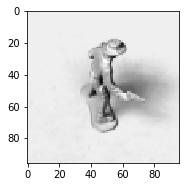

In [29]:
#@title Inspect Dataset

print('Input Shape:')
print(train_x.shape[1:])

print('Train Dataset Size:')
print(train_x.shape[0])

print('Val Dataset Size:')
print(val_x.shape[0])

print('Test Dataset Size:')
print(test_x.shape[0])

import numpy as np
import matplotlib.pyplot as plt

index = np.random.randint(len(train_x))

plt.subplot(1,2,1)
plt.imshow(train_x[index][:,:,0], cmap='gray')

In [0]:
#@title Train & Monitor

from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.optimizers import SGD

initial_epoch = 0
final_epoch = 100
learning_rate = 1e-5
drop_freq_epoch = 10
drop_rate = 0.1

# Checkpoints
checkpoint_batch = ModelCheckpoint('weights-batch.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
checkpoint_local = ModelCheckpoint('weights-local.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Early Stopping
early_batch = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
early_local = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

# Learning Rate Regularizer
def lr_scheduler(epoch):
  return learning_rate * (drop_rate ** (epoch // drop_freq_epoch))

lr_regularizer_batch = LearningRateScheduler(lr_scheduler)
lr_regularizer_local = LearningRateScheduler(lr_scheduler)

# Optimizers
optimizer_batch = SGD(lr=learning_rate, momentum=0.9)
optimizer_local = SGD(lr=learning_rate, momentum=0.9)

# Compile
model_batch.compile(loss='categorical_crossentropy', optimizer=optimizer_batch, metrics=['accuracy'])
model_local.compile(loss='categorical_crossentropy', optimizer=optimizer_local, metrics=['accuracy'])

# Train
hist_batch = model_batch.fit(x=train_x, y=train_y, batch_size=batch_size, initial_epoch=initial_epoch, epochs=final_epoch, validation_data=(val_x, val_y), callbacks=[checkpoint_batch, early_batch, lr_regularizer_batch])
hist_local = model_local.fit(x=train_x, y=train_y, batch_size=batch_size, initial_epoch=initial_epoch, epochs=final_epoch, validation_data=(val_x, val_y), callbacks=[checkpoint_local, early_local, lr_regularizer_local])

Train on 12928 samples, validate on 1536 samples
Epoch 1/100
12928/12928 [==============================] - 92s 7ms/step - loss: 6.1152 - acc: 0.2554 - val_loss: 4.3044 - val_acc: 0.3197

Epoch 00001: val_acc improved from -inf to 0.31966, saving model to weights-batch.h5
Epoch 2/100
12928/12928 [==============================] - 86s 7ms/step - loss: 5.0263 - acc: 0.3640 - val_loss: 3.9830 - val_acc: 0.4069

Epoch 00002: val_acc improved from 0.31966 to 0.40690, saving model to weights-batch.h5
Epoch 3/100
12928/12928 [==============================] - 86s 7ms/step - loss: 4.4995 - acc: 0.4394 - val_loss: 3.6423 - val_acc: 0.5143

Epoch 00003: val_acc improved from 0.40690 to 0.51432, saving model to weights-batch.h5
Epoch 4/100
12928/12928 [==============================] - 86s 7ms/step - loss: 4.2379 - acc: 0.4745 - val_loss: 4.4435 - val_acc: 0.2747

Epoch 00004: val_acc did not improve from 0.51432
Epoch 5/100
12928/12928 [==============================] - 86s 7ms/step - loss: 4.02

In [0]:
#@title Evaluate Models
results_batch = model_batch.evaluate(x=text_x, y=novel_test_y, batch_size=batch_size)
results_local = model_local.evaluate(x=test_x, y=novel_test_y, batch_size=batch_size)

print('BatchNorm Test Accuracy:')
print(results_batch[1])

print('LocalNorm Test Accuracy:')
print(results_local[1])

In [0]:
#@title Save Training 

import json
from google.colab import files

def save_training():
  train_conf = {
      'learning_rate': learning_rate,
      'drop_freq_epoch': drop_freq_epoch,
      'drop_rate': drop_rate
  }
  result_batch = {
      'history': hist_batch.history,
      'results': {
          'test': results_batch
  }
  result_local = {
      'history': hist_local.history,
      'results': {
          'test': results_local
      }
  }
  
  with open('data.json', 'w') as f:
      json.dump(data_conf, f)
  with open('train.json', 'w') as f:
      json.dump(train_conf, f)

  with open('result-batch.json', 'w') as f:
      json.dumps(result_batch)
  with open('result-local.json', 'w') as f:
      json.dumps(result_local)
      
  with open('model-batch.json', 'w') as f:
      f.write(model_batch.to_json())
  with open('model-local.json', 'w') as f:
      f.write(model_local.to_json())

    
def download_training():
  files.download('data.json') 
  files.download('train.json') 
  files.download('model-batch.json') 
  files.download('model-local.json') 
  files.download('result-batch.json') 
  files.download('result-local.json') 
  files.download('weights-batch.json') 
  files.download('weights-local.json') 

save_training()
download_training()

# Test Models

In [0]:
#@title Plot Helper
%matplotlib inline
import matplotlib.pyplot as plt

def plot(metrics, legend=['train', 'test'], title='Model Accuracy', xlabel='epoch', ylabel='accuracy'):
  for metric in metrics:
    plt.plot(metric)
  plt.title(title)
  plt.ylabel(xlabel)
  plt.xlabel(ylabel)
  plt.legend(legend, loc='lower right')
  plt.show()

In [0]:
#@title Load Training

from keras.models import model_from_json

def load_training():
  with open('train.json') as f:
      train_conf = json.load(f)
  with open('data.json') as f:
      data_conf = json.load(f)
  
  with open('model-batch.json', 'r') as f:
      model_batch = model_from_json(f.read())
      model_batch.load_weights('weights-batch.json')
  with open('model-local.json', 'r') as f:
      model_local = model_from_json(f.read())
      model_local.load_weights('weights-local.json')
      
  with open('result-batch.json') as f:
      result_batch = json.load(f)
  with open('result-local.json') as f:
      result_local = json.load(f)
      
  return ( data_conf, train_conf, [ model_batch, model_local ], [ result_batch, result_local ] )

training_results = load_training()
data_conf = training_results[0]
train_conf = training_results[1]
model_batch = training_results[2][0]
model_local = training_results[2][1]
result_batch = training_results[3][0]
result_local = training_results[3][1]

process(data_conf)

## Accuracy Comparison

### Validation Accuracy

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

legend = [ 'batch', 'local']
metrics = [ result_batch['history']['val_acc'], result_local['history']['val_acc'] ]
plot(metrics, legend=legend, title='BatchNorm vs LocalNorm Model Accuracy', xlabel='epoch', ylabel='accuracy')

### Test Accuracy

In [0]:
print('BatchNorm Test Accuracy:')
print(result_batch['test'][1])

print('LocalNorm Test Accuracy:')
print(result_local['test'][1])

### Experiment Accuracy

In [0]:
print('Train Configurations:')
print(train_conf)

print('Test Configurations:')
print(test_conf)

In [0]:
experiment_conf = {
    'elevation': list(range(6)),
    'azimuth': list(range(18)),
    'lighting': list(range(6)),
    'categories': {}
}

def experiment(name, experiment_conf):
  experiment_x, experiment_y = preprocess(test_set, novel_test_conf)
  experiment_x = experiment_x[:((len(experiment_x) // batch_size) * batch_size)]
  experiment_y = experiment_y[:((len(experiment_y) // batch_size) * batch_size)]
  
  experiment_batch = model_batch.evaluate(x=novel_test_x, y=novel_test_y, batch_size=batch_size)
  experiment_local = model_local.evaluate(x=novel_test_x, y=novel_test_y, batch_size=batch_size)

  print('BatchNorm Experiment Accuracy:')
  print(experiment_batch[1])

  print('LocalNorm Experiment Accuracy:')
  print(experiment_local[1])
  
  data_conf[name] = experiment_conf
  result_batch[name] = experiment_batch
  result_local[name] = experiment_local

  with open('data.json', 'w') as f:
      json.dump(data_conf, f)
  with open('result-batch.json', 'w') as f:
      json.dumps(result_batch)
  with open('result-local.json', 'w') as f:
      json.dumps(result_local)
  
experiment('novel-lighting', experiment_conf)